# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

Сначала загрузим необходимые библиотеки.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy.stats.stats import pearsonr
from scipy.stats import f_oneway

In [ ]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

Ознакомимся с предоставленными данными - какие данные представлены и каковы их типы.

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [ ]:
print(df.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

Из сравнения с описанием данных уже можно выявить, какую предобработку необходимо будет совершить - так, столбец is_apartment должен содержать данные о том, является ли недвижимость апартаментами (да/нет - булевый тип), но сейчас имеет тип object, обозначающий строковые переменные. Также видно, какие столбцы, вероятно, являлись обязательными для заполнения, а какие нет - так, данные о числе водоемов присутствуют лишь для трети объектов. Дальнейшее изучение этих проблем пройдет на этапе предобработки данных.

Перед этим оценим, какие значения мы получили в датасете, с помощью гистограмм.

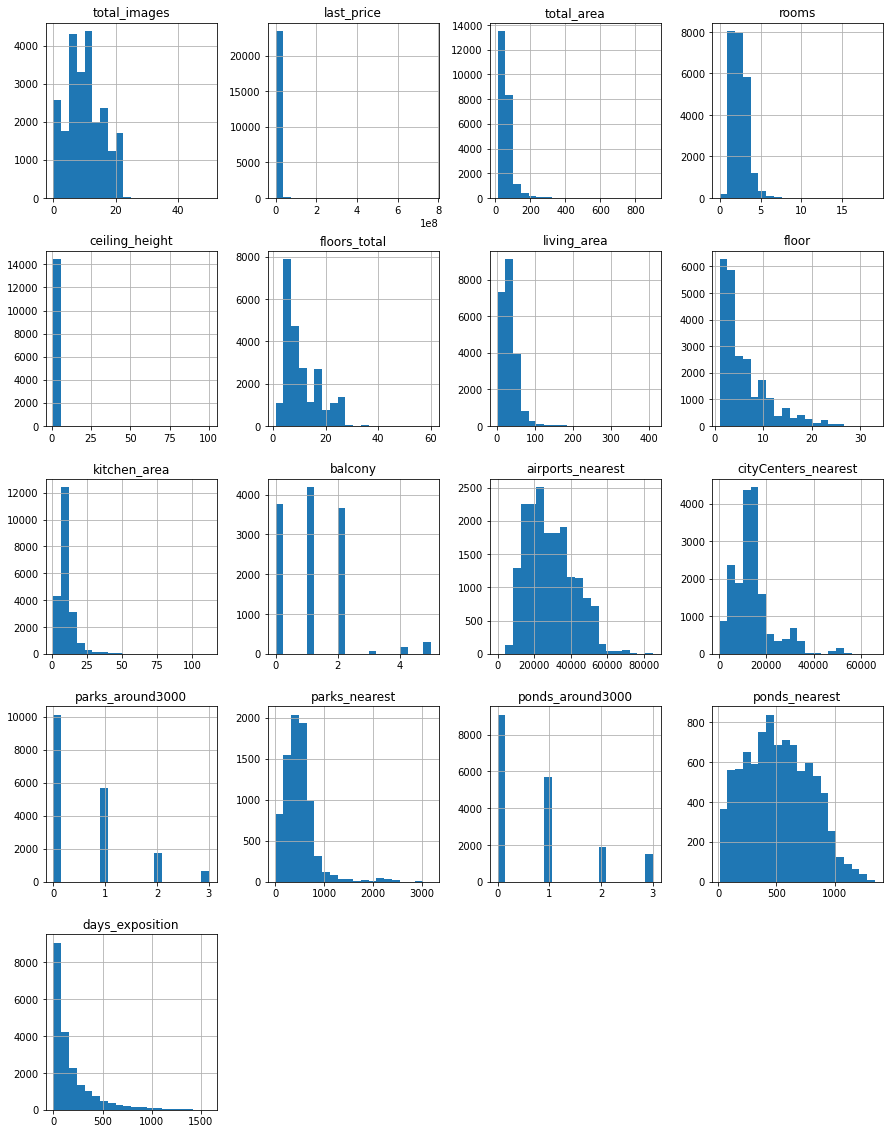

In [ ]:
df.hist(bins=20, figsize=(15, 20));

### Предобработка данных

Определим, в каких столбцах присутствуют пропуски и сколько их.

In [ ]:
print('{0:16} {1}'.format('столбец', 'число пропусков'))
for i in df.columns:
    print('{0:20} {1:5}'.format(i, df[i].isna().sum()))
print()
print('Всего объектов:', df.shape[0])

столбец          число пропусков
total_images             0
last_price               0
total_area               0
first_day_exposition     0
rooms                    0
ceiling_height        9195
floors_total            86
living_area           1903
floor                    0
is_apartment         20924
studio                   0
open_plan                0
kitchen_area          2278
balcony              11519
locality_name           49
airports_nearest      5542
cityCenters_nearest   5519
parks_around3000      5518
parks_nearest        15620
ponds_around3000      5518
ponds_nearest        14589
days_exposition       3181

Всего объектов: 23699


In [ ]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')


,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


Часть данных невозможно восстановить без пользователя (например, число этажей), но есть и те, где можно приблизительно предположить значения для данного объекта - для этого сгруппируем данные по населенному пункту и посмотрим медианное значение (для вещественных чисел, таких как расстояние до ближайшего парка) или моду (для целых чисел, таких как количество парков). 
Есть другой тип пропущенных значений, для которых мы можем сразу заполнить пропуски - для пропущенных в столбце is_apartment поставим значение False (примерно в 80% случаев данные не указывались, но, исходя из определения апартаментов, данные объекты ими не являются - возможно, стоит поместить справку-подсказку для пользователей), а для наличия балкона - 0. 

In [ ]:
df['is_apartment'].fillna(False, inplace=True)
df['balcony'].fillna(0, inplace=True)

Проверим, как прошла замена пропущенных значений.

In [ ]:
print('{0:16} {1}'.format('столбец', 'число пропусков'))
for i in df.columns:
    print('{0:20} {1:5}'.format(i, df[i].isna().sum()))
print()
print('Всего объектов:', df.shape[0])

столбец          число пропусков
total_images             0
last_price               0
total_area               0
first_day_exposition     0
rooms                    0
ceiling_height        9195
floors_total            86
living_area           1903
floor                    0
is_apartment             0
studio                   0
open_plan                0
kitchen_area          2278
balcony                  0
locality_name           49
airports_nearest      5542
cityCenters_nearest   5519
parks_around3000      5518
parks_nearest        15620
ponds_around3000      5518
ponds_nearest        14589
days_exposition       3181

Всего объектов: 23699


Перед тем, как провести замену других значений, необходимо удалить неявные дубликаты в названиях. Создадим новый столбец, содержащий слова, начинающиеся с большой буквы - таким образом, значения "Кудрово" и "деревня Кудрово" дадут одну категорию.

In [ ]:
#выведем значения, которые у нас есть
print(df['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

In [ ]:
#переобозначим невведенные места как "Неизвестно"
df['locality_name'].fillna('Неизвестно', inplace=True)
#создадим столбец для корректных названий
df['place']=''

In [ ]:
#переберем все строчки массива
for i in range(df.shape[0]):
    #разобьем названия по словам
    for word in df['locality_name'][i].split():
        if df['place'][i]=='':
            #если слово начинается с заглавной буквы, то запишем его в новый столбец
            if word.istitle():
                df['place'][i]=word
        else:
            #если мы что-то записали, то надо переносить всю строку до конца
            #пример - названия в духе "поселок Платформа 69-й км"
            df['place'][i]= df['place'][i] + ' '+ word

<ipython-input-13-647e44432476>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['place'][i]=word
<ipython-input-13-647e44432476>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['place'][i]= df['place'][i] + ' '+ word


Проверим, какие у нас получились населенные пункты.

In [ ]:
df['place'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [ ]:
#посчитаем, сколько повторов есть в наших данных
print(df[df.duplicated()])

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, place]
Index: []

[0 rows x 23 columns]


Явных дубликатов нет.
Теперь можем заполнить пропуски в других столбцах. 

In [ ]:
print('{0:16} {1}'.format('столбец', 'число пропусков'))
for i in df.columns:
    print('{0:20} {1:5}'.format(i, df[i].isna().sum()))
print()
print('Всего объектов:', df.shape[0])

столбец          число пропусков
total_images             0
last_price               0
total_area               0
first_day_exposition     0
rooms                    0
ceiling_height        9195
floors_total            86
living_area           1903
floor                    0
is_apartment             0
studio                   0
open_plan                0
kitchen_area          2278
balcony                  0
locality_name            0
airports_nearest      5542
cityCenters_nearest   5519
parks_around3000      5518
parks_nearest        15620
ponds_around3000      5518
ponds_nearest        14589
days_exposition       3181
place                    0

Всего объектов: 23699


In [ ]:
#создадим списки с названиями столбцов, которые хотим поправить
params = ['airports_nearest', 'parks_nearest', 'ponds_nearest', 'ceiling_height', 'parks_around3000', 'ponds_around3000']
#будем перебирать населенные пункты и заменять пропущенное значение медианным значением из имеющихся данных
for i in df['place'].unique():
    for par in params:
        df.loc[(df['place']==i) & (df[par].isna()), par] = df.loc[(df['place']==i) & ~ (df[par].isna()), par].median()

Посмотрим, сколько пропусков удалось поправить таким способом

In [ ]:
print('{0:16} {1}'.format('столбец', 'число пропусков'))
for i in df.columns:
    print('{0:20} {1:5}'.format(i, df[i].isna().sum()))
print()
print('Всего объектов:', df.shape[0])

столбец          число пропусков
total_images             0
last_price               0
total_area               0
first_day_exposition     0
rooms                    0
ceiling_height          95
floors_total            86
living_area           1903
floor                    0
is_apartment             0
studio                   0
open_plan                0
kitchen_area          2278
balcony                  0
locality_name            0
airports_nearest      4829
cityCenters_nearest   5519
parks_around3000      4829
parks_nearest         5998
ponds_around3000      4829
ponds_nearest         4938
days_exposition       3181
place                    0

Всего объектов: 23699


Видим, что в последних столбцах осталось множество пропущенных значений. Рассмотрим на примере данных о расстоянии до аэропорта.

In [ ]:
print(df.loc[df['airports_nearest'].isna(), 'place'].head(10))

5         Янино-1
12      Сертолово
22        Кудрово
30       Коммунар
37    Красный Бор
47        Гатчина
62      Сертолово
64        Гатчина
68    Фёдоровское
69         Выборг
Name: place, dtype: object


In [ ]:
print(df.loc[df['place']=='Гатчина', 'airports_nearest'].unique())

[nan]


То есть, если в городе или поселке аэропорта нет, то значением ставится nan. Эти пропуски мы заполнить не можем.

Перейдем к рассмотрению типов данных.

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23604 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

Отдельно рассмотрим значения столбца о количестве дней размещения объявления.

In [ ]:
print(df['days_exposition'].unique()[:10])

[ nan  81. 558. 424. 121.  55. 155. 189. 289. 137.]


Необходимо изменить типы некоторых столбцов:

floors_total, balcony, parks_around3000, ponds_around3000, days_exposition - к целочисленному типу - это натуральные числа;

first_day_exposition - к типу date-time.

Для удобства работы заполним пропуски заведомо "невозможным" значением -1. 

In [ ]:
for i in ['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']:
    df[i].fillna(-1, inplace=True)

In [ ]:
for i in ['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']:
    df[i] = df[i].astype('int64')

In [ ]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Проверим, как прошла смена типов данных.

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23604 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

Теперь рассмотрим распределение значений с помощью гистограмм.

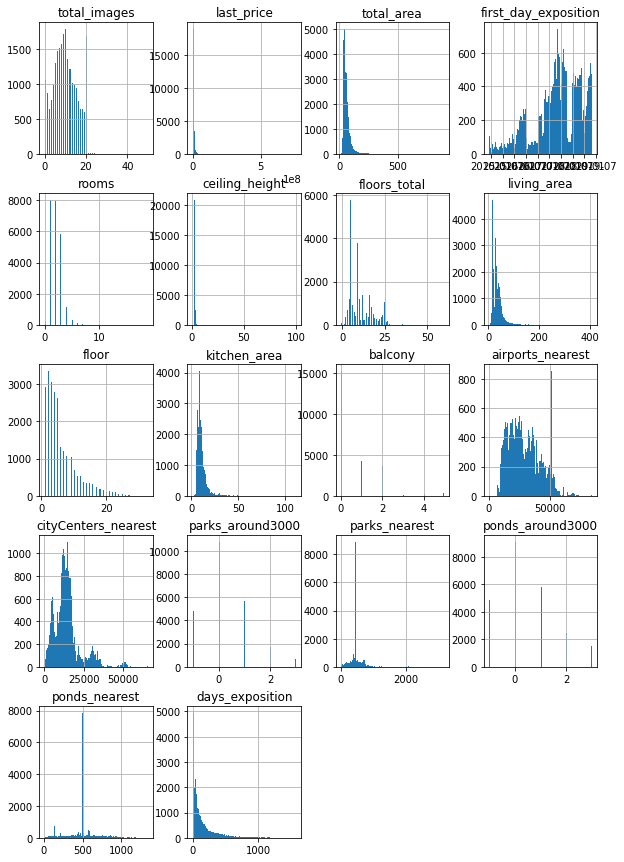

In [ ]:
df.hist(bins=100, figsize=(10,15));

Рассмотрим подробнее некоторые столбцы.

In [ ]:
#сначала посмотрим общую статистику
print(df['last_price'].describe())

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


In [ ]:
#отсортируем по возрастанию
print(df.sort_values('last_price').head())

       total_images  last_price  total_area first_day_exposition  rooms  \
8793              7     12190.0       109.0           2019-03-20      2   
17456             7    430000.0        30.4           2019-04-22      1   
14911             5    430000.0        54.0           2018-06-26      2   
16274            18    440000.0        40.0           2018-07-10      1   
17676             0    450000.0        36.5           2018-02-01      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
8793             2.75            25         32.0     25         False  ...   
17456            2.50             2         16.0      1         False  ...   
14911             NaN             3          NaN      3         False  ...   
16274             NaN             5          NaN      1         False  ...   
17676             NaN             5         17.3      4         False  ...   

       balcony          locality_name  airports_nearest  cityCenters_nearest  \


Можем заключить, что в цене на первой строчке опечатка, ее надо удалить.

Рассмотрим аномально большие значения.

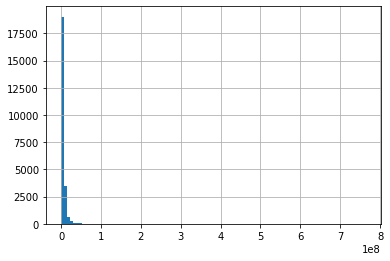

In [ ]:
df['last_price'].hist(bins=100)

In [ ]:
print(df.sort_values('last_price', ascending=False).head())

       total_images   last_price  total_area first_day_exposition  rooms  \
12971            19  763000000.0       400.0           2017-09-30      7   
19540             8  420000000.0       900.0           2017-12-06     12   
14706            15  401300000.0       401.0           2016-02-20      5   
1436             19  330000000.0       190.0           2018-04-04      3   
15651            20  300000000.0       618.0           2017-12-18      7   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
12971             2.7            10        250.0     10         False  ...   
19540             2.8            25        409.7     25         False  ...   
14706             2.7             9        204.0      9         False  ...   
1436              3.5             7         95.0      5         False  ...   
15651             3.4             7        258.0      5         False  ...   

       balcony    locality_name  airports_nearest  cityCenters_nearest  \


Нельзя сказать, что цена здесь является опечаткой, однако при выявлении взаимосвязей такие аномальные значения могут помешать. Создадим новый датасет с более "типичными" значениями.

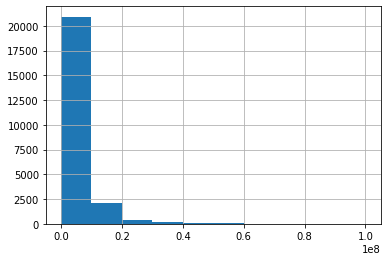

In [ ]:
#определим границы с помощью гистограммы
df['last_price'].hist(range=(0,100000000))

In [ ]:
#введем функцию, которая будет "обрезать" датафрейм по квартилям 5, 95 
#по определенному параметру
def non_outliers(df, par):
    lower_bound = df[par].quantile(q=0.05)
    upper_bound = df[par].quantile(q=0.95)
    return df[(df[par]>lower_bound)|(df[par]<upper_bound)]


In [ ]:
data = non_outliers (df, 'last_price')

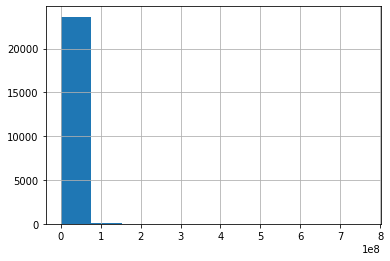

In [ ]:
#построим гистограмму для очищенных данных
data['last_price'].hist()

In [ ]:
#посмотрим еще раз на значения
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Перейдем к следующему параметру - площади. Здесь и далее работаем на новом датасете, "очищенном" от выбросов.

In [ ]:
#сначала рассмотрим общий разброс параметра
print(data['total_area'].describe())

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


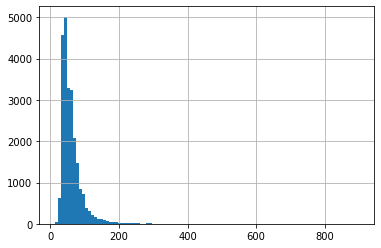

In [ ]:
#рассмотрим на гистограмме
data['total_area'].hist(bins=100)

<div class="alert alert-info"> <b>Комментарии студента:</b> Оставила старое рассмотрение, но обрезала уже по новой функции </div>

In [ ]:
#видно, что объектов с площадью больше 150 мало - посмотрим, где они встречаются
print(data.loc[data['total_area']>150, 'place'].value_counts())

Санкт-Петербург    527
Пушкин              10
Петергоф             3
Красное Село         2
Репино               2
Павловск             2
Сестрорецк           2
Неизвестно           2
Выборг               2
Стрельна             2
Хязельки             1
Колпино              1
Новое Девяткино      1
Сертолово            1
Кронштадт            1
Зеленогорск          1
Всеволожск           1
Парголово            1
Александровская      1
Бор                  1
Name: place, dtype: int64


In [ ]:
print(data.sort_values('total_area', ascending=False).head())

       total_images   last_price  total_area first_day_exposition  rooms  \
19540             8  420000000.0       900.0           2017-12-06     12   
12859            20  140000000.0       631.2           2019-04-09      7   
3117             19  140000000.0       631.0           2019-03-30      7   
15651            20  300000000.0       618.0           2017-12-18      7   
5358             20   65000000.0       590.0           2019-02-14     15   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
19540             2.8            25        409.7     25         False  ...   
12859             3.9             4        322.3      4         False  ...   
3117              2.7             5          NaN      5         False  ...   
15651             3.4             7        258.0      5         False  ...   
5358              3.5             6        409.0      3         False  ...   

       balcony    locality_name  airports_nearest  cityCenters_nearest  \


Судя по другим параметрам (например, цена), это не обязательно неверно заполненные данные, однако в дальнейшем анализе выбросы могут затруднить поиск зависимости.  

In [ ]:
data = non_outliers(data, 'total_area')

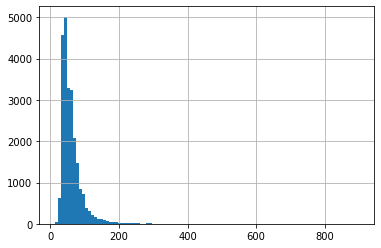

In [ ]:
#еще раз посмотрим на гистограмму
data['total_area'].hist(bins=100)

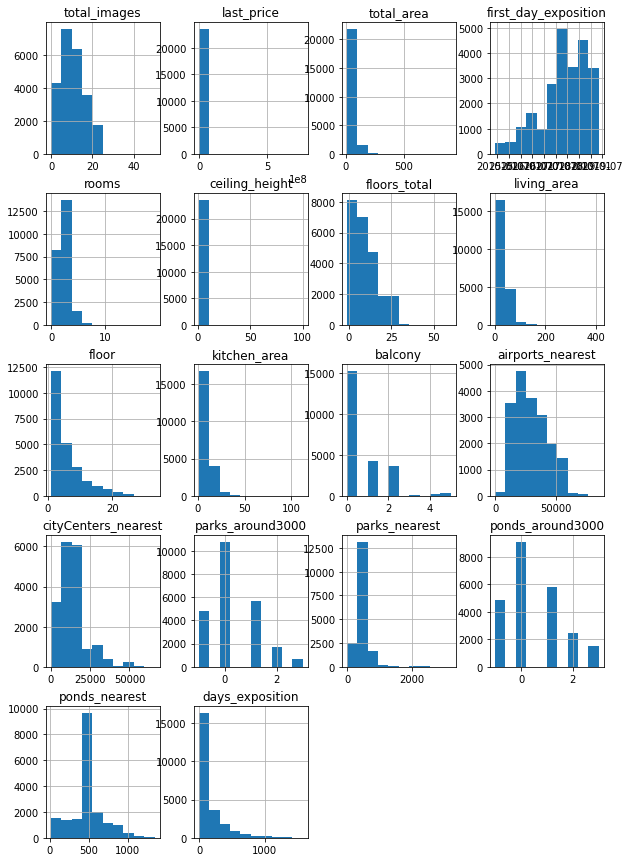

In [ ]:
data.hist(figsize=(10,15));

Следующий параметр - высота потолков.

In [ ]:
print(data['ceiling_height'].describe())

count    23604.000000
mean         2.732684
std          1.003661
min          1.000000
25%          2.550000
50%          2.700000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64


In [ ]:
print(data.sort_values('ceiling_height', ascending=False)['ceiling_height'].head(20))

22869    100.0
22336     32.0
3148      32.0
21377     27.5
5246      27.0
21824     27.0
4876      27.0
10773     27.0
2158      27.0
5807      27.0
20478     27.0
22938     27.0
17857     27.0
5669      26.0
14382     25.0
4643      25.0
11285     25.0
355       25.0
6246      25.0
9379      25.0
Name: ceiling_height, dtype: float64


In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
for i in range(data.shape[0]):
    if data['ceiling_height'][i]>15:
        data['ceiling_height'][i] = data['ceiling_height'][i]/10

<ipython-input-53-0e0c8204a65c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ceiling_height'][i] = data['ceiling_height'][i]/10


In [ ]:
print(data.sort_values('ceiling_height', ascending=False).head())

       total_images  last_price  total_area first_day_exposition  rooms  \
15061            19   5600000.0        56.4           2018-05-11      2   
22309            20   5300000.0        45.0           2017-09-30      1   
22869             0  15000000.0        25.0           2018-07-25      1   
5863             20   5650000.0        45.0           2018-08-15      1   
15743            14   5600000.0        67.0           2016-11-11      3   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
15061            14.0            14         32.4      5         False  ...   
22309            10.3            16         15.5     15         False  ...   
22869            10.0             5         14.0      5          True  ...   
5863              8.3            16         19.3     14         False  ...   
15743             8.0            16         41.0      1         False  ...   

       balcony    locality_name  airports_nearest  cityCenters_nearest  \
15061 

In [ ]:
data=data[data['ceiling_height']<5]

Убрали часть неверно введенных значений.

Аналогично предыдущим случаям удалим часть с аномально большими площадями кухни. 

In [ ]:
print(data['kitchen_area'].describe())

count    21343.000000
mean        10.573909
std          5.899860
min          1.300000
25%          7.000000
50%          9.180000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64


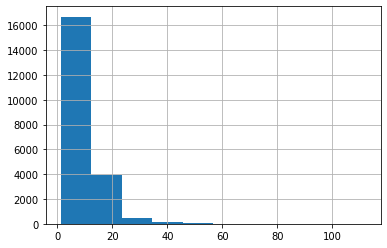

In [ ]:
data['kitchen_area'].hist()

In [ ]:
data = non_outliers(data, 'kitchen_area')
data.reset_index(drop=True, inplace=True)

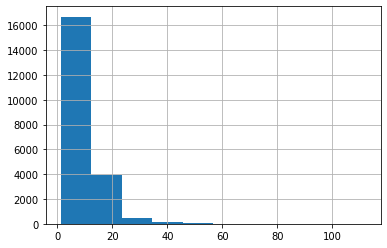

In [ ]:
data['kitchen_area'].hist()

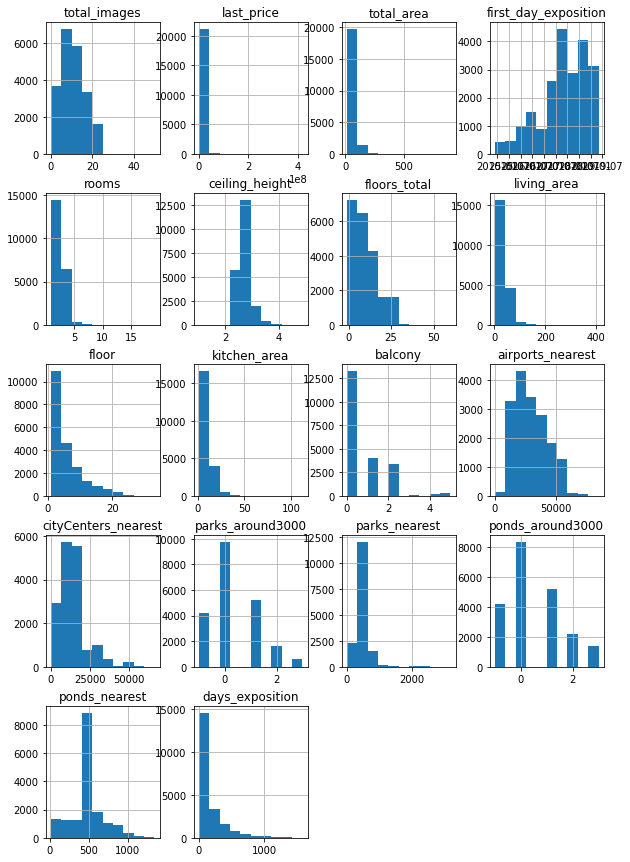

In [ ]:
data.hist(figsize=(10,15));

Исходные данные значительно неоднородны, так как охватывают предложения с огромной области. Представлены разные типы домов со значительно различающимися планировками, что затруднит дальнейший анализ влияния конкретных факторов ценообразования.

Для дальнейшего упрощения предобработки данных следует ввести границы "разумных" значений, чтобы пользователь избежал опечаток (как в случае с высотой потолков). Часть данных можно восстановить по адресу (невозможно в условиях данной задачи, так как дан только город, но возможно в теории, с помощью карт). Возможно, стоит собрать данные о том, как отличается время продажи квартиры с разным числом входных данных.

### Посчитайте и добавьте в таблицу новые столбцы

Добавим некоторые новые столбцы в таблицу.

In [ ]:
#посчитаем цену и проверим реалистичность получившихся значений
data['one_m_price'] = data['last_price']/data['total_area']
print(data['one_m_price'].describe())

count    2.134300e+04
mean     9.941572e+04
std      4.783028e+04
min      1.118349e+02
25%      7.700575e+04
50%      9.504132e+04
75%      1.140351e+05
max      1.736842e+06
Name: one_m_price, dtype: float64


<ipython-input-62-7c2510295d9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['one_m_price'] = data['last_price']/data['total_area']


In [ ]:
#введем столбец с днями недели
data['weekday'] = data['first_day_exposition'].dt.weekday

<ipython-input-63-00de91ac538c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['weekday'] = data['first_day_exposition'].dt.weekday


In [ ]:
#введем столбцы с месяцем и годом публикации объявления
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
3             2  10000000.0       100.0           2018-06-19      2   
4            10   2890000.0        30.4           2018-09-10      1   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70            16         51.0      8         False  ...   
1            2.63            11         18.6      1         False  ...   
2            2.70             5         34.3      4         False  ...   
3            3.03            14         32.0     13         False  ...   
4            2.65            12         14.4      5         False  ...   

   parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
0                 1          482.0                 2     

<ipython-input-64-fbe4edb90d21>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data['first_day_exposition'].dt.month
<ipython-input-64-fbe4edb90d21>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['first_day_exposition'].dt.year


In [ ]:
#определим тип этажа квартиры по категориям первый/последний/другой: 
#функция принимает 2 числа - этаж, на котором находится квартира
#и общее число этажей в доме
def floor_type(floor, total):
    if floor == 1:
        return 'первый'
    elif floor==total:
        return 'последний'
    else:
        return 'другой'

data['floor_type'] = data.apply(lambda x: floor_type(x['floor'],x['floors_total']), axis=1)

<ipython-input-65-717bc25342e3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['floor_type'] = data.apply(lambda x: floor_type(x['floor'],x['floors_total']), axis=1)


In [ ]:
#проверим корректность этого шага
print(data.head(10))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00           2019-03-07      3   
1             7   3350000.0       40.40           2018-12-04      1   
2            10   5196000.0       56.00           2015-08-20      2   
3             2  10000000.0      100.00           2018-06-19      2   
4            10   2890000.0       30.40           2018-09-10      1   
5             6   3700000.0       37.30           2017-11-02      1   
6             5   7915000.0       71.60           2019-04-18      2   
7            20   2900000.0       33.16           2018-05-23      1   
8            18   5400000.0       61.00           2017-02-26      3   
9             5   5050000.0       39.60           2017-11-16      1   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70            16        51.00      8         False  ...   
1            2.63            11        18.60      1         False  ...

In [ ]:
#пересчитаем расстояние до центра города в км 
data['cent_dist'] = (data['cityCenters_nearest']/1000)
data['cent_dist'].fillna(-1.0, inplace=True)
data['cent_dist'] = data['cent_dist'].astype('int64')
print(data['cent_dist'].head())

0    16
1    18
2    13
3     8
4    -1
Name: cent_dist, dtype: int64


<ipython-input-67-7aae9112ac67>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cent_dist'] = (data['cityCenters_nearest']/1000)
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
<ipython-input-67-7aae9112ac67>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

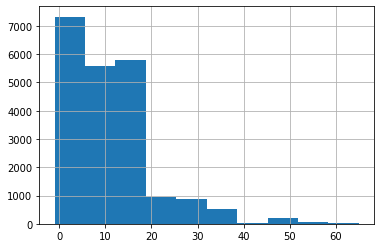

In [ ]:
#посмотрим на распределение полученных данных
data['cent_dist'].hist()

### Проведите исследовательский анализ данных

Построим гистограммы числовых параметров.

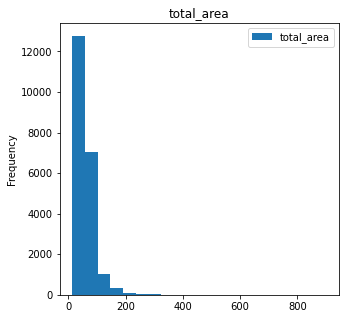

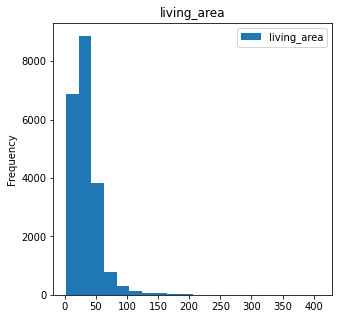

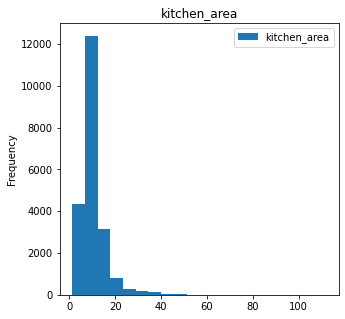

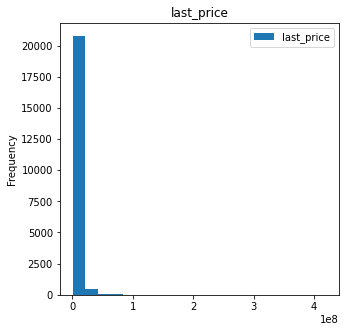

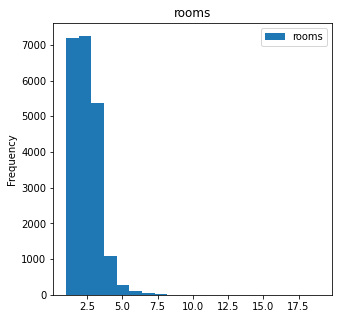

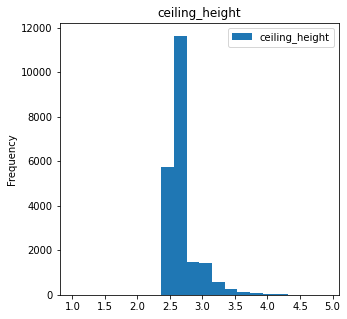

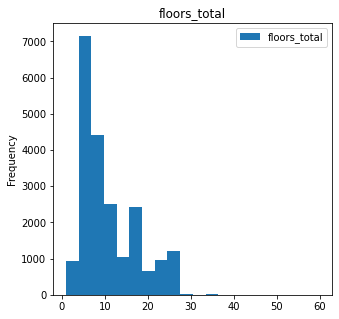

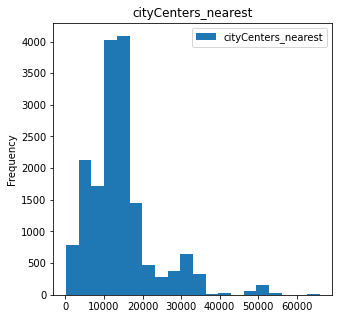

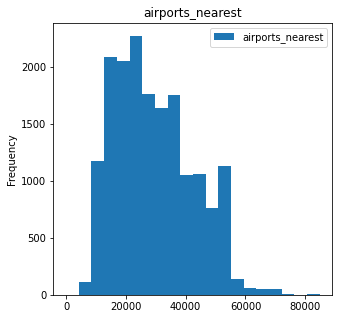

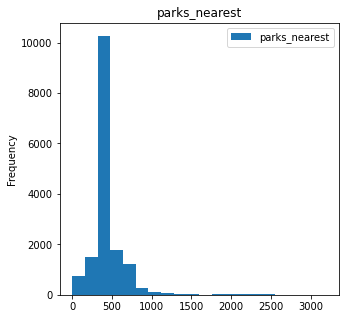

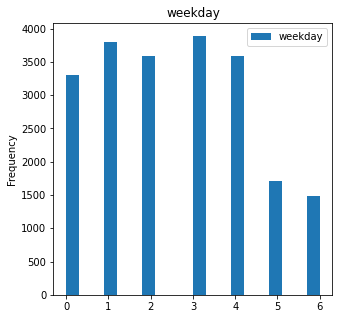

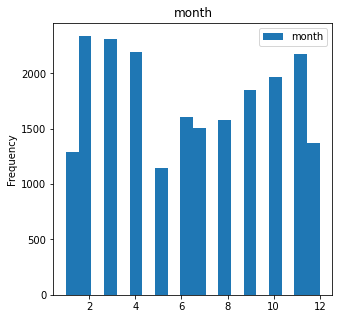

In [ ]:
#перечислим параметры, для которых будем строить гистограммы
par = ['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height', 'floors_total', 'cityCenters_nearest', 'airports_nearest', 'parks_nearest', 'weekday',
       'month']

for i in par:
    data.loc[data[i]>=0].plot(y=i, kind='hist', title=i, figsize=(5,5), bins=20)



<BarContainer object of 3 artists>

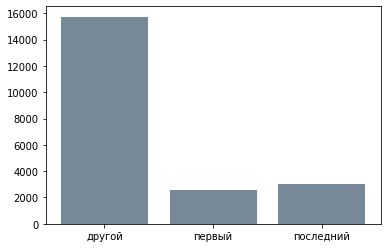

In [ ]:
label = data['floor_type'].unique()
values = list(map(lambda x: data.loc[data['floor_type']==x]['floor_type'].count(), label))

plt.bar(label, values, color ='lightslategray')


Из представленных гистограмм можем заключить, что данные не подвержены нормальному распределению и имеют "хвост" из дорогих больших квартир. Выделяются пики, по-видимому, характерные для квартир с разным числом комнат. Высота потолков имеет наименьшую вариативность из представленных параметров. Наибольшую - расстояние до аэропорта. 

В летние месяцы публикуется меньше объявлений, чем в зимние. 

Рассмотрим, сколько времени объявление о продаже квартиры находится на сайте.

In [ ]:
print('Среднее время нахождения объявления на сайте, дн.:', data.loc[data['days_exposition']>=0]['days_exposition'].mean().round(),)
print('Медианное время нахождения объявления на сайте, дн:', data.loc[data['days_exposition']>=0]['days_exposition'].median())

Среднее время нахождения объявления на сайте, дн.: 186.0
Медианное время нахождения объявления на сайте, дн: 102.0


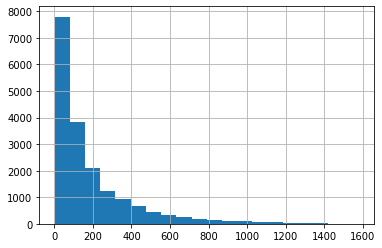

In [ ]:
data.loc[data['days_exposition']>=0]['days_exposition'].hist(bins=20)

Среднее время (186 дней) почти в 2 раза превосходит медианное (102 дня), что говорит о наличии объявлений, которые "висят" на сайте значительное время. Это же подтверждается гистограммой.

Отдельно рассмотрим, как продаются объявления до полугода и некоторые характеристики быстро и медленно продающихся квартир. 

Рассмотрим, какие значения соответствуют квартилям .05 и .95.

In [ ]:
print('0.05 квантиль, дн.')
print(data.loc[data['days_exposition']>=0]['days_exposition'].quantile(0.05))
print()
print('0.95 квантиль, дн.')
print(data.loc[data['days_exposition']>=0]['days_exposition'].quantile(0.95))

0.05 квантиль, дн.
9.0

0.95 квантиль, дн.
658.0


Мы не можем установить, почему эти "быстрые" продажи были такими быстрыми - либо квартира была продана, либо объявление было просто закрыто. Судьба квартир с "долгими" продажами также нам неизвестна. 

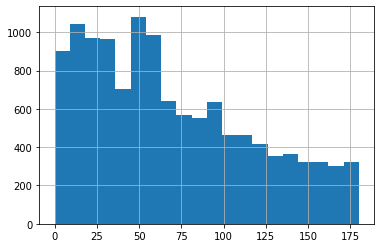

In [ ]:
data.loc[data['days_exposition']>=0]['days_exposition'].hist(bins=20, range=(0, 180))

Рассмотрим, в каких городах квартиры продаются за месяц (будем считать 30 дней границей быстрой продажи), а в каких - больше 200 дней.

In [ ]:
print('Места, где квартиры продаются быстро:')
print(data.loc[(data['days_exposition']<9) & (data['days_exposition']>=0)]['place'].value_counts().head(10))
print()
print('Всего таких:', data.loc[(data['days_exposition']<9) & (data['days_exposition']>=0)]['place'].count())
print()
print('Места, где квартиры продаются долго:')
print(data.loc[data['days_exposition']>658]['place'].value_counts().head(10))
print()
print('Всего таких:', data.loc[data['days_exposition']>658]['place'].count())

Места, где квартиры продаются быстро:
Санкт-Петербург    641
Мурино              26
Кудрово             19
Парголово           18
Колпино             17
Пушкин              15
Шушары              14
Гатчина             13
Всеволожск           9
Выборг               7
Name: place, dtype: int64

Всего таких: 901

Места, где квартиры продаются долго:
Санкт-Петербург    642
Кудрово             19
Гатчина             16
Пушкин              15
Мурино              15
Всеволожск          14
Петергоф            14
Шушары              13
Выборг              11
Коммунар             9
Name: place, dtype: int64

Всего таких: 918


Видим, что в топе примерно одни и те же населенные пункты. Возможно, проблема в других параметрах.


In [ ]:
print('Медианная цена квартир, которые продаются быстро:')
print(data.loc[(data['days_exposition']<9) & (data['days_exposition']>=0)]['last_price'].median())
print()
print('Медианная цена квартир, которые продаются долго:')
print(data.loc[data['days_exposition']>658]['last_price'].median())

Медианная цена квартир, которые продаются быстро:
4400000.0

Медианная цена квартир, которые продаются долго:
5550000.0


In [ ]:
print('Медианная площадь квартир, которые продаются быстро:')
print(data.loc[(data['days_exposition']<9) & (data['days_exposition']>=0)]['total_area'].median())
print()
print('Медианная площадь квартир, которые продаются долго:')
print(data.loc[data['days_exposition']>658]['total_area'].median())

Медианная площадь квартир, которые продаются быстро:
46.0

Медианная площадь квартир, которые продаются долго:
60.0


In [ ]:
print('Медианное расстояние до центра квартир, которые продаются быстро:')
print(data.loc[(data['days_exposition']<9) & (data['days_exposition']>=0)]['cent_dist'].median())
print()
print('Медианное расстояние до центра квартир, которые продаются долго:')
print(data.loc[data['days_exposition']>658]['cent_dist'].median())

Медианное расстояние до центра квартир, которые продаются быстро:
12.0

Медианная цена квартир, которые продаются долго:
7.0


Как видим, рассмотренные параметры различаются - долго продающиеся квартиры больше, дороже, ближе к центру. Однако достаточно ли отличие, чтобы описать причины, по которым квартиры не продаются, нельзя сказать из предоставленных данных.

Далее изучим влияние различных факторов на стоимость квартиры. 

In [ ]:
sns.set_theme(style="ticks")

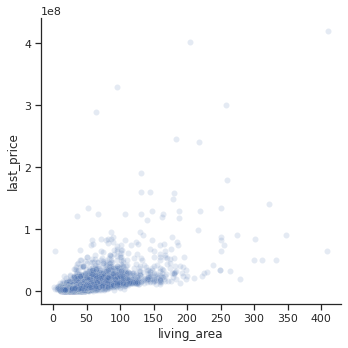

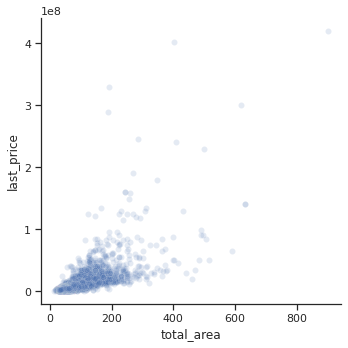

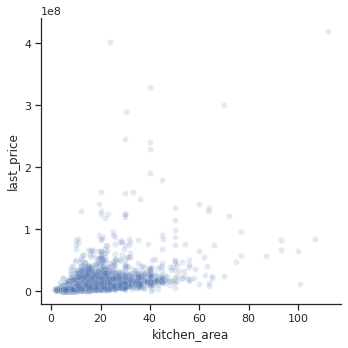

In [ ]:
#перечислим параметры, влияние которых будем изучать
params_float = ['living_area', 'total_area', 'kitchen_area']
params_int = ['weekday', 'month', 'year', 'rooms']
params_cat = 'floor_type'

#нарисуем графики в соответствии с типом данных
for i in params_float:
    sns.relplot(x=i, y='last_price', data=data, alpha=0.15)


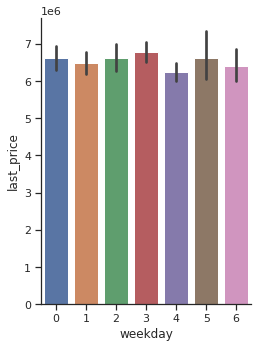

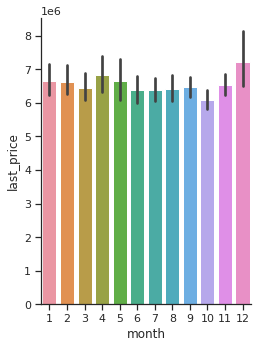

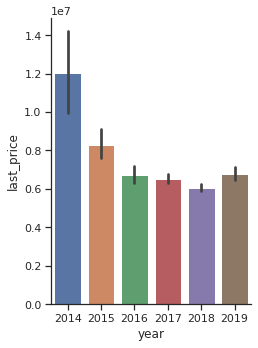

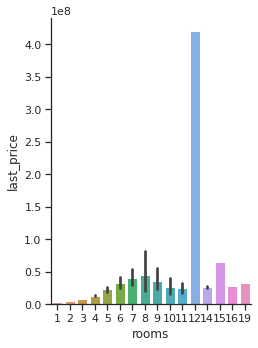

In [ ]:
for i in params_int:
    sns.catplot(x=i, y='last_price', data=data, kind='bar', aspect=0.75)

Видим значительно выбивающуюся квартиру с 12 комнатами, однако для квартир вне элитного сегмента зависимость явно прослеживается.

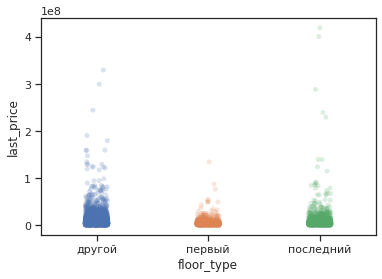

In [ ]:
sns.stripplot(x=params_cat, y='last_price', data=data, alpha=0.2)

Проверим с помощью коэффициента корреляции Пирсона, есть ли взаимосвязь между ценой и этими параметрами.

In [ ]:

for i in (params_float+params_int):
    test = pearsonr(data.loc[~data[i].isna()][i],data.loc[~data[i].isna()]['last_price'])
    if test[1]<0.05:
        print('Корреляция между ценой квартиры и параметром', i, 'присутствует.')
        print('p-value равно {0:.2}, коэффициент корреляции {1:.2}'.format(test[1], test[0]))
    else:
        print('Корреляции между параметром', i, 'и ценой квартиры не выявлено.')
        print('p-value равно {:.2}'.format(test[1]))

Корреляция между ценой квартиры и параметром living_area присутствует.
p-value равно 0.0, коэффициент корреляции 0.6
Корреляция между ценой квартиры и параметром total_area присутствует.
p-value равно 0.0, коэффициент корреляции 0.7
Корреляция между ценой квартиры и параметром kitchen_area присутствует.
p-value равно 0.0, коэффициент корреляции 0.52
Корреляции между параметром weekday и ценой квартиры не выявлено.
p-value равно 0.44
Корреляции между параметром month и ценой квартиры не выявлено.
p-value равно 0.81
Корреляция между ценой квартиры и параметром year присутствует.
p-value равно 3.8e-09, коэффициент корреляции -0.04
Корреляция между ценой квартиры и параметром rooms присутствует.
p-value равно 0.0, коэффициент корреляции 0.39


In [ ]:
stat = f_oneway(data.loc[data['floor_type']=='другой']['last_price'], data.loc[data['floor_type']=='последний']['last_price'], data.loc[data['floor_type']=='первый']['last_price'])
if stat[1]<0.05:
    print('У квартир с разными типами этажей (первый/последний/другой) стоимость значительно различается')
    print('p-value равно {:.2}'.format(stat[1]))
else:
    print('Разницы в стоимости у квартир с разными типами этажей (первый/последний/другой) на уровне значимости 0.05 не выявлено')
    print('p-value равно {:.2}'.format(stat[1]))

У квартир с разными типами этажей (первый/последний/другой) стоимость значительно различается
p-value равно 1.1e-20


Таким образом, мы можем сделать следующие выводы: 



*   Площадь квартиры влияет на ее стоимость
*   Общая площадь квартиры влияет на стоимость сильнее, чем жилая площадь или площадь кухни
* День недели, в который было опубликовано объявление, не влияет на стоимость квартиры 
* Несмотря на то, что есть разница между количеством объявлений, публикуемых в разные месяцы, стоимость квартиры от числа предложений на рынке не зависит
* Цены за период наблюдений практически не менялись (коэффициент корреляции близок к 0)
* Чем больше в квартире комнат, тем она дороже
* Квартиры на первом и последнем этажах статистически значимо дешевле квартир на других этажах



Рассмотрим цену квадратного метра в наиболее популярных городах и населенные пункты, где квадратный метр дороже или дешевле всего.

In [ ]:
#создадим новую таблицу, в которой рассчитаем медианную цену квадратного метра 
#и число объявлений
#для каждого населенного пункта
price_per_m = data.pivot_table(index='place', values='one_m_price', aggfunc=['median', 'count'])
print(price_per_m.head())

                       median       count
                  one_m_price one_m_price
place                                    
Агалатово        75709.779180           3
Александровская  70262.807084           2
Аннино           64103.084416          14
Барышево         31250.000000           1
Батово           31253.755558           6


In [ ]:
print('Места с самым дорогим квадратным метром')
print(price_per_m['median']['one_m_price'].sort_values(ascending=False).head())

Места с самым дорогим квадратным метром
place
Репино             127678.571429
Бор                105539.261570
Санкт-Петербург    104444.444444
Зеленогорск        100000.000000
Пушкин             100000.000000
Name: one_m_price, dtype: float64


In [ ]:
print('Места с самым дешевым квадратным метром')
print(price_per_m['median']['one_m_price'].sort_values().head())

Места с самым дешевым квадратным метром
place
Совхозный       12555.555556
Ефимовский      12686.567164
Житково         14956.275202
Почап           16037.735849
Бокситогорск    16112.903226
Name: one_m_price, dtype: float64


In [ ]:
print('Цена м2 в местах с наибольшим числом объявлений')
print(price_per_m.sort_values(by=('count', 'one_m_price'), ascending=False)['median'].head(10))

Цена м2 в местах с наибольшим числом объявлений
                   one_m_price
place                         
Санкт-Петербург  104444.444444
Мурино            84922.646605
Шушары            77223.320158
Кудрово           95588.235294
Всеволожск        65789.473684
Пушкин           100000.000000
Колпино           74723.748474
Гатчина           67860.569236
Парголово         92261.904762
Выборг            58407.079646


In [ ]:
data.groupby('locality_name').agg({'balcony':'count', 'last_price':'median'}) \
    .sort_values(by = 'balcony', ascending = False) \
    .head(10)

,balcony,last_price
locality_name,,
Санкт-Петербург,14334,5550000.0
посёлок Мурино,422,3550000.0
посёлок Шушары,398,3970000.0
Всеволожск,357,3450000.0
Пушкин,338,5200000.0
Колпино,322,3600000.0
Гатчина,294,3100000.0
посёлок Парголово,289,4130000.0
деревня Кудрово,231,3865000.0


Рассчитаем, как меняется стоимость квартир в Петербурге в зависимости от расстояния до центра города.

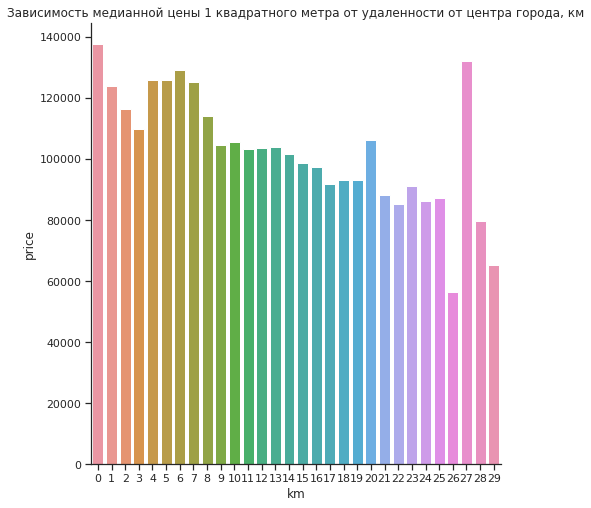

In [ ]:
#создадим новый датафрейм 
spb_dist = data.loc[data['place']=='Санкт-Петербург'].loc[data['cent_dist']>=0].pivot_table(index='cent_dist', values='one_m_price', aggfunc='median')
spb_dist.reset_index(inplace=True)
spb_dist.columns=['km','price']
sns.catplot(x='km', y='price', data=spb_dist, kind='bar', height=7)
plt.title('Зависимость медианной цены 1 квадратного метра от удаленности от центра города, км');

In [ ]:
test = pearsonr(spb_dist.loc[~spb_dist['km'].isna()]['km'],spb_dist.loc[~spb_dist['km'].isna()]['price'])
if test[1]<0.05:
    print('Корреляция между ценой квартиры и параметром', 'km', 'присутствует.')
    print('p-value равно {0:.2}, коэффициент корреляции {1:.2}'.format(test[1], test[0]))
else:
    print('Корреляции между параметром', 'km', 'и ценой квартиры не выявлено.')
    print('p-value равно {:.2}'.format(test[1]))

Корреляция между ценой квартиры и параметром km присутствует.
p-value равно 9.3e-07, коэффициент корреляции -0.76


Видим, что, несмотря на выброс в районе 20 км, наблюдается сильная корреляция - чем дальше квартиры от центра, тем они дешевле. 

### Общий вывод

В ходе работы над проектом была проведена предобработка данных: определены пропущенные значения, частично они были заполнены по данным тех же населенных пунктов. В названиях населенных пунктов предварительно устранены неявные дубликаты. Изменены неверно введенные данные, аномалии в данных были отброшены и не использовались для дальнейшего анализа. 

Затем были рассчитаны параметры, изначально напрямую не представленные в данных, но необходимые для анализа, такие как цена квадратного метра, месяц и год публикации объявления.

Далее построены гистограммы для числовых параметров и отмечены особенности в данных: 

*   Данные не подвержены нормальному распределению и имеют "хвост" из дорогих больших квартир. 
*   В данных выделяются пики, характерные для квартир с разным числом комнат.
* В летние месяцы публикуется меньше объявлений о продаже квартир, чем в зимние.
* В среднем объявление находилось на сайте 180 дней, но медианное значение того же параметра - 98. Это говорит о том, что есть объявления, которые находятся на сайте очень длительное время (несколько лет) и неадекватно завышают среднее значение. Можно выделить группу "быстрых" (до 30 дней) и "долгих" (больше 200 дней) объявлений. Причину попадания каждого конкретного объявления в одну из групп не удалось - необходимы дальнейшие исследования.


Далее исследовалось влияние различных факторов на стоимость квартиры: 

*   Площадь квартиры и число комнат ожидаемо влияют на стоимость квартиры, причем наибольшее влияние оказывает общая площадь
* Квартиры на первом и последнем этажах статистически значимо дешевле квартир на других этажах
*   Несмотря на то, что есть разница между количеством объявлений, публикуемых в разные месяцы, стоимость квартиры от числа предложений на рынке не зависит

Были рассчитаны медианные цены квадратного метра в каждом населенном пункте. Наиболее популярным городом ожидаемо стал Санкт-Петербург (102598 за м2), а самым дорогим - поселок Репино в Курортном районе (127678 за м2).

Далее были рассмотрены квартиры только в Санкт-Петербурге и было статистически подстверждено утверждение о том, что квартиры дальше от центра города дешевле.


